In [16]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torch.nn import functional as F

tqdm.pandas()

In [17]:
import itertools

In [18]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1,2"

In [19]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Current cuda device: 0
Count of using GPUs: 3


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device:', device)  # 출력결과: cuda 
print('Count of using GPUs:', torch.cuda.device_count())   #출력결과: 2 (2, 3 두개 사용하므로)
print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)

Device: cuda
Count of using GPUs: 3
Current cuda device: 0


In [22]:
# device = 'cpu'

In [23]:
config = dict(imgsize = 256,
              batch_size = 128 if False else 2,
              input_nc = 3,
              output_nc = 3,
              lr = 2e-4,
              epoch = 0,
#               n_epochs = 150,
              n_epochs = 150,
              decay_epoch = 15,
              path = '20231018_02')

# Dataset & DataLoader

In [24]:
basePath = '../Data/최종납품데이터_데이타플로우'
imageList = sorted(os.listdir(basePath))

state = []
pk = []
headPart = []


for image in imageList:
    split = image.split('_')
    state.append(split[0][1])
    pk.append(split[1])
    headPart.append(split[2][0])
    
df_origin = pd.DataFrame({'path' : [os.path.join(basePath, path) for path in imageList],
                          'pk' : pk,
                          'state' : state,
                          'headPart' : headPart})

df_origin['pk'] = df_origin['state'] + df_origin['pk']

a_df = df_origin.loc[(df_origin['headPart'] == 'b') & (df_origin['state'].isin(['0', '1']))]
b_df = df_origin.loc[(df_origin['headPart'] == 'b') & (df_origin['state'].isin(['3', '4']))]
a_df = a_df.iloc[:len(b_df)]

In [25]:
###################33
a_df = a_df.iloc[:640]
b_df = b_df.iloc[:640]

In [26]:
# calculate mean, std
tmp_df = df_origin.loc[(df_origin['headPart'] == 'b')]

def computeMeanStd(tmp_df, imageSize = (256, 256)):    
    transform = transforms.Compose([
        transforms.Resize(imageSize),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x[:3])
    ])
    
    mean = 0.0
    std = 0.0
    
    for path in tqdm(tmp_df['path']):
        image = Image.open(path)
        image = transform(image)
        image = image.view(image.size(0), -1)
        mean += image.mean(1)
        std += image.std(1)
        
    mean /= len(tmp_df)
    std /= len(tmp_df)
    
    return mean, std

# mean, std = computeMeanStd(tmp_df)

In [27]:
mean = [0.5154, 0.4467, 0.4580]
std = [0.1901, 0.1830, 0.1907]

In [28]:
class CustomCycleGANDataset(Dataset):
    def __init__(self, df, mean, std):
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3]),
            transforms.Normalize(mean = mean, std = std),
            transforms.RandomHorizontalFlip(p = 0.7),
#             transforms.RandomRotation(degrees=(-20, 20), interpolation = transforms.BILINEAR, fill = 0)            
        ])
#         self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx]['path'])
        imgae = image.convert('RGB')
        image = self.transform(image)
        return image
#         return image.to(device)

In [29]:
custom_datasetA = CustomCycleGANDataset(a_df, mean, std)
custom_datasetB = CustomCycleGANDataset(b_df, mean, std)
dataloaderA = DataLoader(custom_datasetA, batch_size=config['batch_size'], shuffle=True)
dataloaderB = DataLoader(custom_datasetB, batch_size=config['batch_size'], shuffle=True)

# Model

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features*2

        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        out_features = in_features//2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, padding=1),
                  nn.InstanceNorm2d(512), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [31]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [32]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
#         assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [33]:
netG_A2B = Generator(config['input_nc'], config['output_nc'])
netG_B2A = Generator(config['input_nc'], config['output_nc'])
netD_A = Discriminator(config['input_nc'])
netD_B = Discriminator(config['output_nc'])

In [34]:
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

print('Weights Initialized')

/home/wesleyquest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


Weights Initialized


In [35]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    netG_A2B = nn.DataParallel(netG_A2B)
    netG_B2A = nn.DataParallel(netG_B2A)
    netD_A = nn.DataParallel(netD_A)
    netD_B = nn.DataParallel(netD_B)

netG_A2B = netG_A2B.to(device)
netG_B2A = netG_B2A.to(device)
netD_A = netD_A.to(device) 
netD_B = netD_B.to(device) 

Let's use 3 GPUs!


In [36]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=config['lr'], betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=config['lr'], betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=config['lr'], betas=(0.5, 0.999))

# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(config['n_epochs'], config['epoch'], config['decay_epoch']))
# lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(config['n_epochs'], config['epoch'], config['decay_epoch']))
# lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(config['n_epochs'], config['epoch'], config['decay_epoch']))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(config['n_epochs'], config['epoch'], config['decay_epoch']).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(config['n_epochs'], config['epoch'], config['decay_epoch']).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(config['n_epochs'], config['epoch'], config['decay_epoch']).step)

In [37]:
target_real = torch.ones(config['batch_size'], dtype=torch.float).unsqueeze(1).to(device)
target_fake = torch.ones(config['batch_size'], dtype=torch.float).unsqueeze(1).to(device)

In [38]:
!nvidia-smi

Thu Oct 19 01:26:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   35C    P2    55W / 250W |    801MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 23%   

In [39]:
print(config['n_epochs'])

150


In [ ]:
loader_len = len(dataloaderA)

###### Training ######
for epoch in tqdm(range(config['epoch'], config['n_epochs'])):
    total_loss_D_real = 0
    total_loss_D_fake = 0
    total_loss_D_B = 0
    total_loss_D_A = 0
    total_loss_GAN_A2B = 0
    total_loss_GAN_B2A = 0
    total_loss_cycle_ABA = 0
    total_loss_cycle_BAB = 0
    
    for real_A, real_B in zip(dataloaderA, dataloaderB):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
    
        optimizer_G.zero_grad()

        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real) 

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * 10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * 10.0

        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward(retain_graph = True)
        
        
        optimizer_D_A.zero_grad()

        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        pred_fake = netD_A(fake_A)
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        
        optimizer_D_B.zero_grad()

        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        pred_fake = netD_B(fake_B)
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        
        optimizer_G.step()
        optimizer_D_A.step()
        optimizer_D_B.step()
        
        total_loss_D_real += loss_D_real.to('cpu').detach()
        total_loss_D_fake += loss_D_fake.to('cpu').detach()
        total_loss_D_B += loss_D_B.to('cpu').detach()
        total_loss_D_A += loss_D_A.to('cpu').detach()
        total_loss_GAN_A2B += loss_GAN_A2B.to('cpu').detach()
        total_loss_GAN_B2A += loss_GAN_B2A.to('cpu').detach()
        total_loss_cycle_ABA += loss_cycle_ABA.to('cpu').detach()
        total_loss_cycle_BAB += loss_cycle_BAB.to('cpu').detach()
    
    print(f'EPOCH: {epoch} finish.')
    pd.DataFrame({'epoch' : [epoch],
                  'total_loss_D_real' : [total_loss_D_real],
                  'total_loss_D_fake' : [total_loss_D_fake],
                  'total_loss_D_B' : [total_loss_D_B],
                  'total_loss_D_A' : [total_loss_D_A],
                  'total_loss_GAN_A2B' : [total_loss_GAN_A2B],
                  'total_loss_GAN_B2A' : [total_loss_GAN_B2A],
                  'total_loss_cycle_BAB' : [total_loss_cycle_BAB],
                  'total_loss_cycle_ABA' : [total_loss_cycle_ABA]}).to_csv("../Result/" + config['path'] + ".csv", 
                                                                           mode = 'a', 
                                                                           header = False)
    
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
with open('../Result/' + config['path'] + '.pickle', 'wb') as f:
    pickle.dump([netG_A2B, netG_B2A], f)
    
with open('../Result/' + config['path'] +'_A2B' '.pickle', 'wb') as a2b:
    torch.save(netG_A2B.state_dict(), a2b)
    
with open('../Result/' + config['path'] +'_B2A' '.pickle', 'wb') as b2a:
    torch.save(netG_B2A.state_dict(), b2a)   

# Loss

In [99]:
loss_df = pd.read_csv(f'../Result/{config["path"] + ".csv"}', 
                      header = None)

loss_df.columns = ['0', 'epoch', 'total_loss_D_real', 'total_loss_D_fake',
                   'total_loss_D_B','total_loss_D_A',
                   'total_loss_GAN_A2B', 'total_loss_GAN_B2A',
                   'total_loss_cycle_BAB', 'total_loss_cycle_ABA']

loss_df.drop(columns = ['0'], inplace = True)
for column in loss_df.columns[1:]:
    loss_df[column] = loss_df[column].str.extract(r'(\d.*)')
    loss_df[column] = loss_df[column].apply(lambda x : float(x.replace(')', '')))

In [103]:
loss_df.head(2)

,epoch,total_loss_D_real,total_loss_D_fake,total_loss_D_B,total_loss_D_A,total_loss_GAN_A2B,total_loss_GAN_B2A,total_loss_cycle_BAB,total_loss_cycle_ABA
0,0,3.6201,3.7708,3.6954,4.7923,3.7708,4.9656,2197.2915,2382.2407
1,1,3.3297,3.7191,3.5244,3.3110,3.7191,3.3262,2045.0419,2162.8054


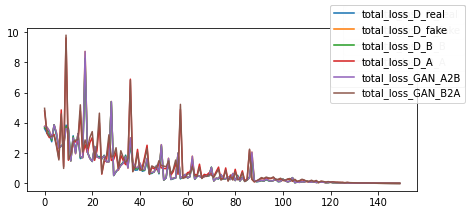

In [108]:
fig, ax = plt.subplots(figsize = (7, 3))

for column in loss_df.columns[1:7]:
    ax.plot(loss_df['epoch'], loss_df[column], label = column)
    fig.legend()

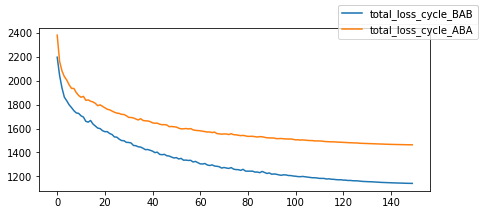

In [109]:
fig, ax = plt.subplots(figsize = (7, 3))

for column in loss_df.columns[7:]:
    ax.plot(loss_df['epoch'], loss_df[column], label = column)
    fig.legend()

# Predict

In [154]:
a2b = Generator(input_nc=3, output_nc=3, n_residual_blocks=9)
a2b.load_state_dict(torch.load('../Result/' + config['path'] +'_A2B' '.pickle', map_location = torch.device(device)), strict = False) 
a2b.to(device)

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (

In [155]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x[:3]),
    transforms.Normalize(mean=mean, std=std)
])

In [162]:
a_image = Image.open(a_df.iloc[2]['path'])

input_a_image = transform(a_image).unsqueeze(0)  # Add an extra dimension for batch (1 image)

if torch.cuda.is_available():
    input_a_image = input_a_image.to(device)

a2b.eval()
with torch.no_grad():
    output_image_B = a2b(input_a_image)
    output_image_B = output_image_B.squeeze(0)  # Remove the batch dimension

    # Convert the tensor to a PIL image
    output_image_B = transforms.ToPILImage()(output_image_B.to('cpu'))

    # Resize the image
    output_image_B = output_image_B.resize((270, 480))
    output_image_B = np.array(output_image_B)

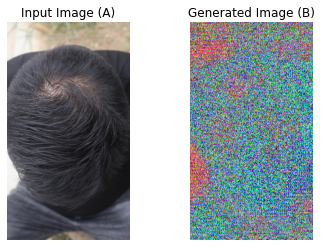

In [163]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Input Image (A)')
plt.imshow(a_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Generated Image (B)')
plt.imshow(output_image_B)
plt.axis('off')

plt.show()

In [46]:
a_image = Image.open(a_df.iloc[2]['path'])

input_a_image = transform(a_image).unsqueeze(0)  # Add an extra dimension for batch (1 image)

if torch.cuda.is_available():
    input_a_image = input_a_image.to(device)

netG_A2B.eval()
with torch.no_grad():
    output_image_B = netG_A2B(input_a_image)
    output_image_B = output_image_B.squeeze(0)  # Remove the batch dimension

    # Convert the tensor to a PIL image
    output_image_B = transforms.ToPILImage()(output_image_B.to('cpu'))

    # Resize the image
    output_image_B = output_image_B.resize((270, 480))
    output_image_B = np.array(output_image_B)

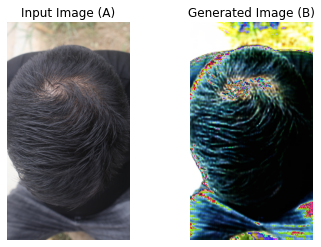

In [47]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Input Image (A)')
plt.imshow(a_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Generated Image (B)')
plt.imshow(output_image_B)
plt.axis('off')

plt.show()

In [48]:
b_image = Image.open(b_df.iloc[2]['path'])

input_b_image = transform(b_image).unsqueeze(0)  # Add an extra dimension for batch (1 image)

if torch.cuda.is_available():
    input_b_image = input_b_image.to(device)

netG_B2A.eval()
with torch.no_grad():
    output_image_A = netG_B2A(input_b_image)
    output_image_A = output_image_A.squeeze(0)  # Remove the batch dimension

    # Convert the tensor to a PIL image
    output_image_A = transforms.ToPILImage()(output_image_A.to('cpu'))

    # Resize the image
    output_image_A = output_image_A.resize((270, 480))
    output_image_A = np.array(output_image_A)

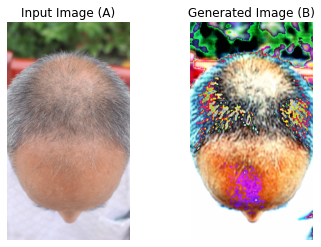

In [49]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Input Image (A)')
plt.imshow(b_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Generated Image (B)')
plt.imshow(output_image_A)
plt.axis('off')

plt.show()